In [1]:
import pandas as pd
import numpy as np
from gensim.models.fasttext import FastText
from string import punctuation
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, regexp_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

import matplotlib.pyplot as plt
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spenc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spenc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\spenc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
data = pd.read_csv("PrePostQuestions.csv")

In [3]:
data.head()

,asin,question,item_name,hours_diff,label
0,B017PICGL0,Are boots cold reliable?,"Reebok Work Men's Zigkick RB7005 Work Shoe, Br...",-1.0,Pre
1,B01HI8YEZS,is the main body rubber or plastic?,"3C-Aone Galaxy S5 Case,Mangix Built-in Glass L...",21.0,Pre
2,B07GZ1LF4R,Do you know the thread pitch/count for the tang?,"ColdLand |14.00"" Hand Forged Damascus Steel Bl...",166.0,Post
3,B07BMNPRFN,The item ordered came tarnished and my son nee...,BEICHUANG Beidou 7 Stars Big Dipper Star Penda...,116.0,Post
4,B075QQKFK3,"""I purchased these and now they look weird wit...",Alla Lighting H8 H11 LED Bulbs Xtreme Super Br...,1021.0,Post


In [4]:
data = data.drop(['asin', 'hours_diff', 'item_name'], axis=1)
data.label = [1 if x == 'Post' else 0 for x in data.label]
data['q_lowered'] = data.question.apply(lambda x: x.lower())

# tokenize raw question
data['raw_tokenized_question'] = data.q_lowered.apply(word_tokenize) # word_tokenize or text_to_word_sequence

In [5]:
data

,question,label,q_lowered,raw_tokenized_question
0,Are boots cold reliable?,0,are boots cold reliable?,"[are, boots, cold, reliable, ?]"
1,is the main body rubber or plastic?,0,is the main body rubber or plastic?,"[is, the, main, body, rubber, or, plastic, ?]"
2,Do you know the thread pitch/count for the tang?,1,do you know the thread pitch/count for the tang?,"[do, you, know, the, thread, pitch/count, for,..."
3,The item ordered came tarnished and my son nee...,1,the item ordered came tarnished and my son nee...,"[the, item, ordered, came, tarnished, and, my,..."
4,"""I purchased these and now they look weird wit...",1,"""i purchased these and now they look weird wit...","[``, i, purchased, these, and, now, they, look..."
...,...,...,...,...
232487,Does this have a pad in the bottom?,0,does this have a pad in the bottom?,"[does, this, have, a, pad, in, the, bottom, ?]"
232488,Is this safe for dogs that swim in pond?,1,is this safe for dogs that swim in pond?,"[is, this, safe, for, dogs, that, swim, in, po..."
232489,"If I buy an additional valve, can I run the ma...",0,"if i buy an additional valve, can i run the ma...","[if, i, buy, an, additional, valve, ,, can, i,..."
232490,These keep disconnecting and reconnecting to m...,1,these keep disconnecting and reconnecting to m...,"[these, keep, disconnecting, and, reconnecting..."


In [6]:
# train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('label', axis=1), data.label, 
                                                    test_size=0.2, stratify=data.label, random_state=628)

In [7]:
# look at top words for each label before any engineering
pre_words = [word for wordlist in X_train.loc[y_train[y_train == 0].index].raw_tokenized_question for word in wordlist]
post_words = [word for wordlist in X_train.loc[y_train[y_train == 1].index].raw_tokenized_question for word in wordlist]

In [8]:
pre_mc = Counter(pre_words).most_common()
post_mc = Counter(post_words).most_common()

In [9]:
pre_df = pd.DataFrame.from_dict(list({x[0]: x[1] for x in pre_mc[:100]}.items()))
pre_df.columns = ['word','count']

post_df = pd.DataFrame.from_dict(list({x[0]: x[1] for x in post_mc[:100]}.items()))
post_df.columns = ['word','count']

In [10]:
# words in pre top 100 but not in post top 100
set(pre_df.word).difference(set(post_df.word))

{'3',
 '4',
 '5',
 'case',
 'color',
 'dimensions',
 'made',
 'many',
 'model',
 'phone',
 'same',
 'two',
 'want',
 'which',
 'your'}

In [11]:
# words in post top 100 but not in pre top 100
set(post_df.word).difference(set(pre_df.word))

{'after',
 'bought',
 'did',
 'mine',
 'no',
 'off',
 'ordered',
 'received',
 'replacement',
 'return',
 't',
 'take',
 'time',
 'was',
 'way'}

In [12]:
# looks like there is some ok word differences between the labels

In [13]:
# look at tfid on raw lowercased text for a baseline

tfidf = TfidfVectorizer(stop_words=None, ngram_range =(1, 3), sublinear_tf=True, 
                        max_df = 0.75, min_df = 2) # , preprocessor=' '.join
tfidf.fit(X_train.q_lowered)
X_test_tfidf = tfidf.transform(X_test.q_lowered)

In [14]:
# wanted to look at top tfidf scores by label but didn't have time

# top_k = sorted(zip(tfidf.vocabulary_, tfidf.idf_), key=lambda x: x[1], reverse=True)[0:1000]
# tfidf_dict = {z[0]: z[1] for z in top_k}

In [15]:
# top_pre_post={}
# def get_top(x):
#     tfidf_grams = [w for w in set(tfidf_dict.keys()) if w in ' '.join(x)]
#     print(tfidf_grams)
    
# data[data.label == 0].raw_tokenized_question.apply(get_top)

In [16]:
X_reduced = TruncatedSVD(n_components=4, n_iter=25, random_state=22).fit_transform(X_test_tfidf)

In [17]:
def plot_3d(x, y, z, labels):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x[np.where(labels == 0)], y[np.where(labels == 0)], z[np.where(labels == 0)], 
               marker='.', alpha=.5, label='pre')
    ax.scatter(x[np.where(labels == 1)], y[np.where(labels == 1)], z[np.where(labels == 1)], 
               marker='+', label='post')
    ax.set_xlabel('comp_1')
    ax.set_ylabel('comp_2')
    ax.set_zlabel('comp_3')
    plt.legend()
    plt.show()

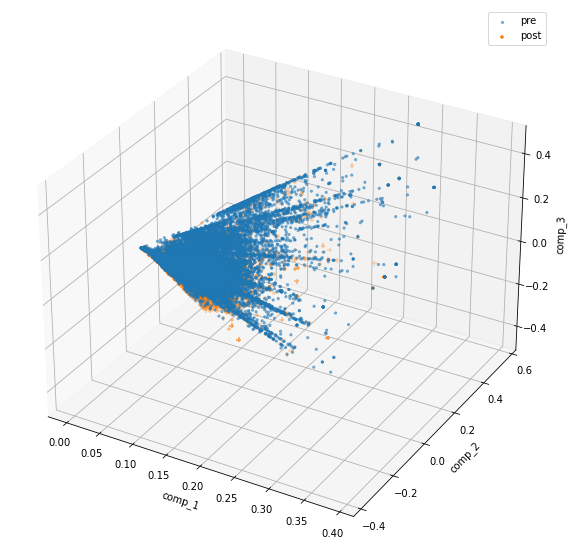

In [18]:
# 3d plot on test set
plot_3d(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2], y_test)

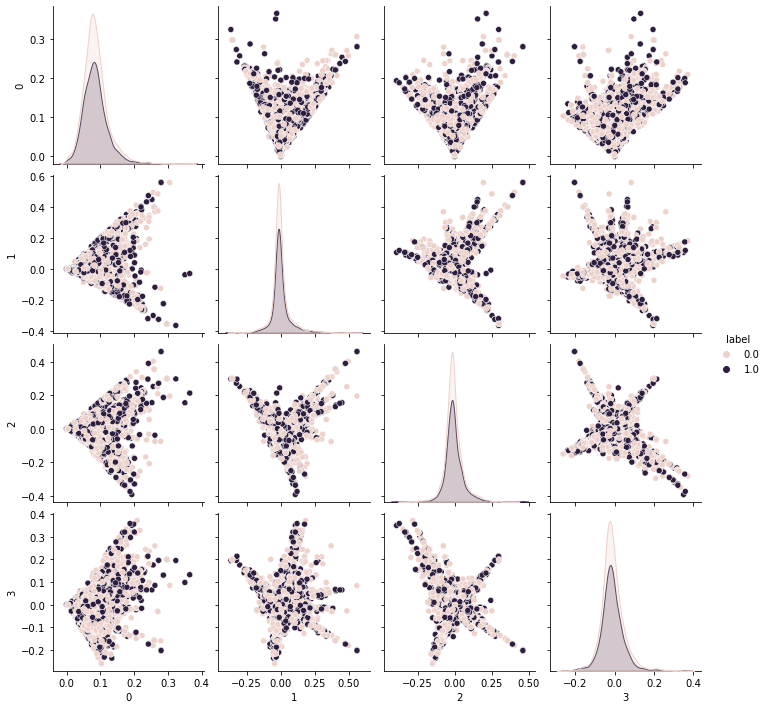

In [19]:
# plot on test set

plot_df = pd.DataFrame(X_reduced)
plot_df['label'] = y_test
sns.pairplot(plot_df, hue="label")
plt.show()

In [20]:
######## try some standard NLP preprocessing techniques below ############

In [21]:
# function to return a wordnet pos compatible with lemmatizer
def pos_wn(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [22]:
# define stopwords with punctuation
stop_words = stopwords.words("english") + list(punctuation)
wordnet_lemmatizer = WordNetLemmatizer()
ps =PorterStemmer()

# function to pos_tag, lemmatize w/ pos_tag, remove 2 character or less words and stopwords
def stopwords_lemm_num_text(lowercase_tokens):
    pos_tokens = pos_tag(lowercase_tokens)
    tagged = list(map(lambda x: (x[0], pos_wn(x[1])), pos_tokens)) 
    tokens = [wordnet_lemmatizer.lemmatize(w) if pos is None 
              else wordnet_lemmatizer.lemmatize(w, pos) for w, pos in tagged if w.isalpha()]
#     tokens = [ps.stem(w) for w in tokens]
    tokens = [w for w in tokens if len(w) > 2]
    tokens = [w for w in tokens if w not in stop_words]
    if len(tokens) == 0:
        return None
    return tokens

In [23]:
# apply the transformations on raw tokenized text
X_train['question_processed'] = X_train.raw_tokenized_question.apply(stopwords_lemm_num_text)
X_test['question_processed'] = X_test.raw_tokenized_question.apply(stopwords_lemm_num_text)

In [24]:
# drop rows where the transform resulted in no tokens (empty token list)

X_train_pro = X_train[~X_train.question_processed.isna()]
y_train_pro = y_train[X_train_pro.index]

X_test_pro = X_test[~X_test.question_processed.isna()]
y_test_pro = y_test[X_test_pro.index]

In [25]:
tfidf = TfidfVectorizer(stop_words=None, ngram_range =(1, 3), sublinear_tf=True, 
                        max_df = 0.75, min_df = 2, preprocessor=' '.join)
tfidf.fit(X_train_pro.question_processed)
X_test_processed_tfidf = tfidf.transform(X_test_pro.question_processed)

X_test_reduced = TruncatedSVD(n_components=4, n_iter=25, random_state=22).fit_transform(X_test_processed_tfidf)

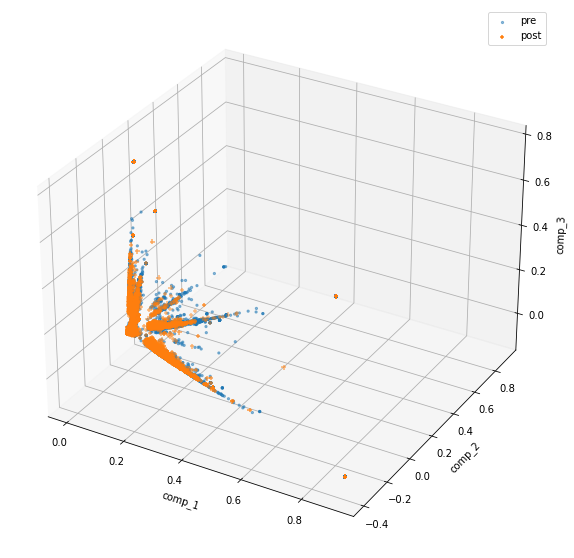

In [26]:
plot_3d(X_test_reduced[:,0], X_test_reduced[:,1], X_test_reduced[:,2], y_test_pro)

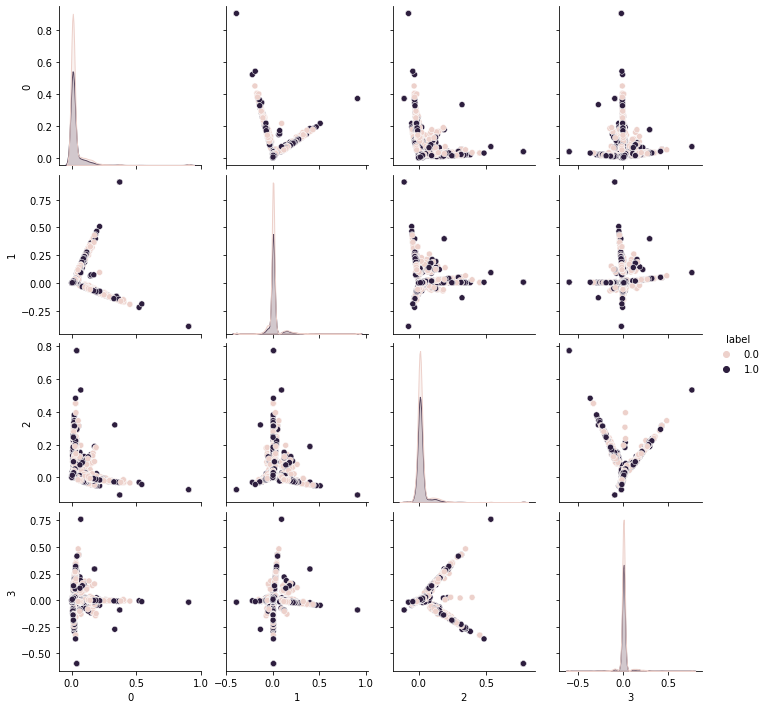

In [27]:
plot_df = pd.DataFrame(X_test_reduced)
plot_df['label'] = y_test_pro
sns.pairplot(plot_df, hue="label")
plt.show()

In [28]:
# try a fasttext model

In [29]:
from gensim.models import FastText
import multiprocessing
cores = multiprocessing.cpu_count()

# train FastText
model = FastText(vector_size=250, window=5, sg=1, min_count=1, 
                 sentences=X_train_pro.question_processed, epochs=50, workers=-1) 


In [30]:
data_cat_ft_emb = pd.DataFrame([np.mean(model.wv[X_test_pro.loc[r].question_processed], axis=0) for r in X_test_pro.index])

In [31]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

pca = PCA(n_components=4)
pca_res = pca.fit_transform(data_cat_ft_emb)

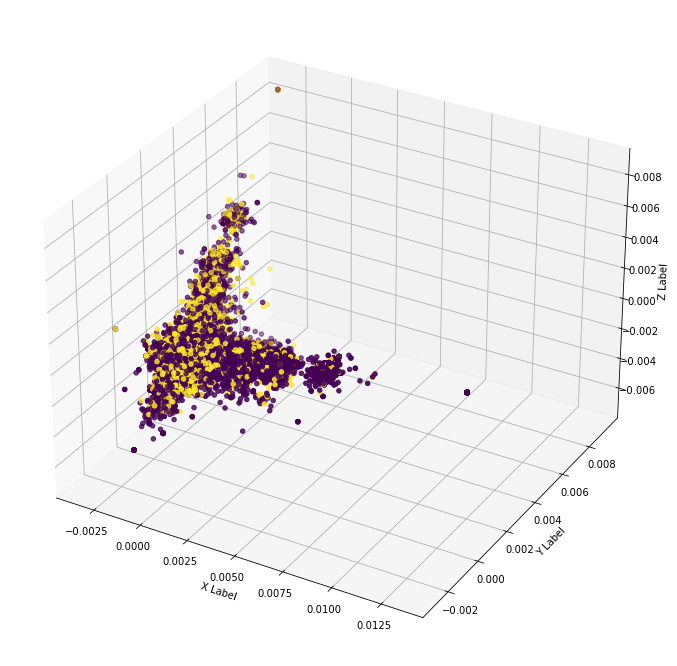

In [32]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_res[:,0], pca_res[:,1], pca_res[:,2], c=y_test_pro)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

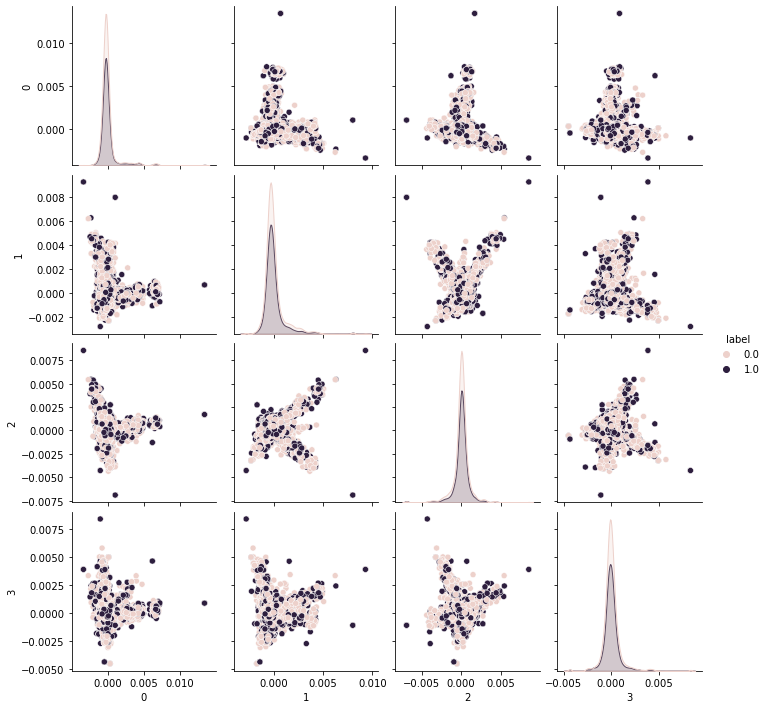

In [33]:
plot_df = pd.DataFrame(pca_res)
plot_df['label'] = y_test_pro
sns.pairplot(plot_df, hue="label")
plt.show()

In [34]:
# undersample
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(data_cat_ft_emb, y_test_pro)

Using TensorFlow backend.


In [35]:
pca = PCA(n_components=4)
pca_res = pca.fit_transform(X_resampled)

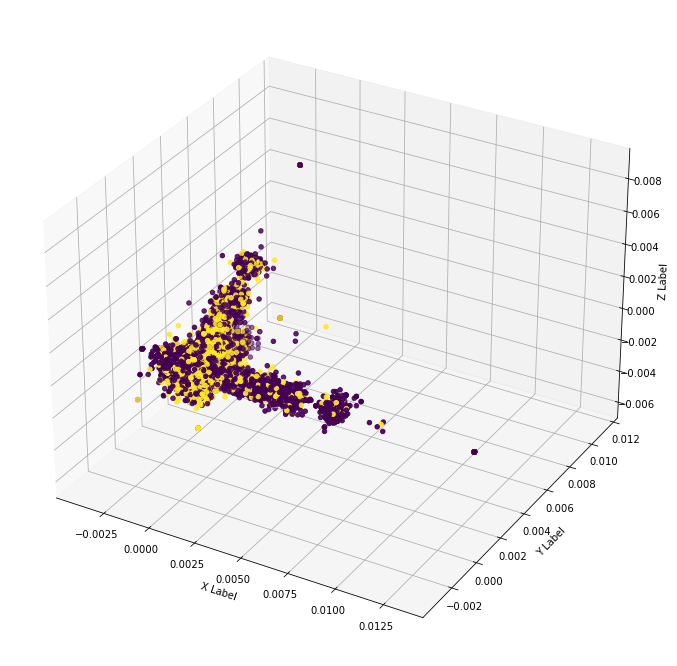

In [36]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_res[:,0], pca_res[:,1], pca_res[:,2], c=y_resampled)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

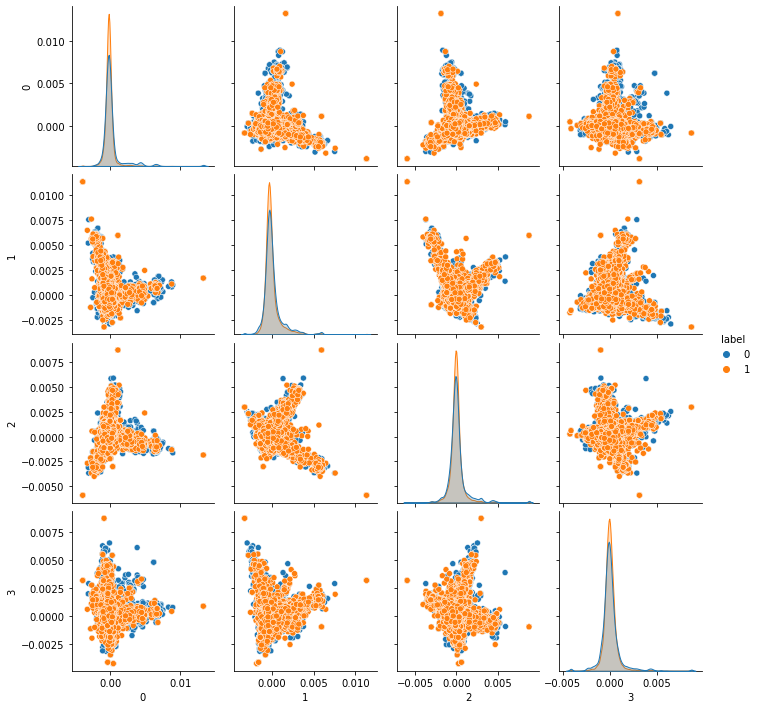

In [37]:
plot_df = pd.DataFrame(pca_res)
plot_df['label'] = y_resampled
sns.pairplot(plot_df, hue="label")
plt.show()

Not a whole lot of success with some of these transformations.  The TFIDF could be dropped straight into some models that accept sparse matricies.  The fasttext embedding I would encode into an embedding matrix to be passed into a neural net and map each word token to it's embedding.  The tokens would also need to be padded so they are all the same length.  This way I could use the word vector from each word in a question rather than having to average them together.  

If I were to continue working on this I would really dig into exploring if the transformations really worked.  I suspect removing some of the stopwords didn't help based on the context of the problem.  

Also there is a tremendous amount of overlap it seems so I would look to create a custom stopword list and remove words that don't explain variance in the label.  

I would explore using a Chi2 or some other type of feature selection. 

I used undersampling here but I would dig a little deeper into balancing the classes and the best way to acheive that. 

I wanted to see how using a BERT model with fine tuning would work here but didn't have time.  This would be a good route to explore.  

In [38]:
# chi2 feature selector on tfidf

In [39]:
# stemming or lemmitization of words, stopword removal?, number removal?, 

In [40]:
# word counts by label - top words by label or use tfidf fot this

In [41]:
# tfidf to t-sne viz

In [42]:
# find words most common to both labels and make those the stop words

In [43]:
# fasttext embedding to pca viz

In [44]:
# transfer learning , bert maybe?  to viz